# Home Sales - King County, Washington
## Model evaluation, model selection, and feature selection

### Danielle Su (ds3731)


The data we will be looking at are a subset of home sales data from King County, Washington, as we might see on a real-estate website.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

## Part 1: Regression

Here we try to build a model to predict adjusted sales price from a set of building features.

### Load data

In [2]:
# Load data from file
infile_name = '../data/house_sales_subset_normed.csv'
df = pd.read_csv(infile_name)

# Use a subset of the columns as features
X = df[['SqFtTotLiving_norm','SqFtLot_norm','Bathrooms','Bedrooms','TrafficNoise']]

# Extract the target, adjusted sale price, in values of $100,000
y_r = df.AdjSalePrice / 100000

### Create a held-aside set

In [3]:
# Split into 80% train and 20% test using train_test_split and random_state=42
from sklearn.model_selection import train_test_split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, 
                                                            y_r, 
                                                            test_size=.2,
                                                            random_state=42)

### Measure baseline performance

In [5]:
# Instantiate and train a dummy model on the training set using DummyRegressor
from sklearn.dummy import DummyRegressor
dummy_r = DummyRegressor().fit(X_train_r, y_train_r)


In [6]:
# Calculate and print RMSE training set error of the dummy model
from sklearn.metrics import mean_squared_error
dummy_r_training_rsme = np.sqrt(mean_squared_error(y_train_r, dummy_r.predict(X_train_r)))
print('dummy RMSE: {:.3f}'.format(dummy_r_training_rsme))

dummy RMSE: 2.162


In [7]:
# Calculate and print the R2 training set score of the dummy model
dummy_r_training_r2 = dummy_r.score(X_train_r, y_train_r)
print('dummy R2: {:.3f}'.format(dummy_r_training_r2))

dummy R2: 0.000


In [8]:
# Calculate and print the mean 5-fold cross valication R2 score of the dummy model
from sklearn.model_selection import cross_val_score
dummy_r_cv = cross_val_score(dummy_r, X_train_r, y_train_r, cv=5)
print('dummy mean cv R2: {:.3f}'.format(np.mean(dummy_r_cv)))

dummy mean cv R2: -0.000


### Measure performance of Linear Regression

In [9]:
# Instantiate and train a LinearRegression model on the training set
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train_r, y_train_r)

In [10]:
# Calculate RMSE training set error of the linear model
lr_rmse = np.sqrt(mean_squared_error(y_train_r, lr.predict(X_train_r)))
print('lr RMSE: {:.3f}'.format(lr_rmse))

lr RMSE: 1.584


In [11]:
# Calculate and print the R2 training set score of the linear model
lr_r2 = lr.score(X_train_r, y_train_r)
print('lr R2: {:.4f}'.format(lr_r2))

lr R2: 0.4630


In [20]:
# Calculate mean 5-fold Cross Validation R2 score of the linear model on the training set using cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train_r, y_train_r, cv=5)
print('lr mean cv R2: {:.4f}'.format(np.mean(scores)))

lr mean cv R2: 0.4616


### Model selection

In [21]:
# We'll also train an Elastic Net model using regularization
# Perform GridSearch over different proportions of the l1_ratio = [.1,.5,.9,1] using the training set
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
params = {'l1_ratio' : [.1,.5,.9,1]}
gs = GridSearchCV(ElasticNet(), params).fit(X_train_r, y_train_r)

In [24]:
# Print out the best R2 score found using grid search and the best parameter setting found
print('gs best R2 score : {:.4f}'.format(gs.best_score_))
print('gs best params: {}'.format(gs.best_params_))

gs best R2 score : 0.2989
gs best params: {'l1_ratio': 0.1}


In [25]:
# Using the best parameter setting found via cross validation in the step before
#   calculate and print the mean 5-fold cv R2 score on the training set
en = ElasticNet(l1_ratio= gs.best_params_['l1_ratio'])
scores = cross_val_score(en, X_train_r, y_train_r, cv=5)
print('en mean cv R2  : {:.4f}'.format(np.mean(scores)))

en mean cv R2  : 0.2990


In [26]:
# Retrain the ElasticNet model on the full training set and get predictions on the full training set
en.fit(X_train_r, y_train_r)
y_hat = en.predict(X_train_r)

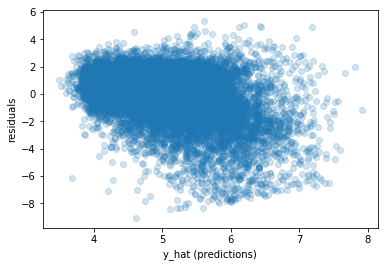

In [27]:
# Plot predictions (x-axis) vs residuals (y-axis) using plt.scatter() with alpha=0.2
residuals = y_hat - y_train_r
_ = plt.scatter(y_hat, residuals, alpha=0.2)
_ = plt.ylabel('residuals')
_ = plt.xlabel('y_hat (predictions)')

### Evaluate trained models on Test

In [28]:
# Using our trained models, calculate RMSE on the test set
print('dummy_r test RMSE  : {:.3f}'.format(np.sqrt(mean_squared_error(y_test_r, dummy_r.predict(X_test_r)))))
print('lr test RMSE       : {:.3f}'.format(np.sqrt(mean_squared_error(y_test_r, lr.predict(X_test_r)))))
print('en test RMSE       : {:.3f}'.format(np.sqrt(mean_squared_error(y_test_r, en.predict(X_test_r)))))


dummy_r test RMSE  : 2.152
lr test RMSE       : 1.582
en test RMSE       : 1.800


### Feature selection

In [29]:
# Using the ElasticNet model we trained before, what features have a non-zero coefficient?
print('kept columns: {}'.format(list(X.columns[en.coef_ != 0])))


kept columns: ['SqFtTotLiving_norm', 'Bathrooms', 'Bedrooms']


In [30]:
# Now, select the top 3 most informative features from the trained model 
from sklearn.feature_selection import SelectKBest, f_regression
skb = SelectKBest(f_regression, k=3).fit(X_train_r, y_train_r)

In [31]:
# Print out the selected features using skb.get_support() and the column names from X_train_r
kept_columns = list(X.columns[skb.get_support()])
print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving_norm', 'Bathrooms', 'Bedrooms']


---

## Part 2: Classification

Here we try to build a model to predict low vs. high adjusted sales price.

### Create classification target

In [32]:
# First, we create a binary target by thresholding at the median of our AdjSalePrice in $100,000
y_c = (df.AdjSalePrice > df.AdjSalePrice.median()).astype(int)

In [33]:
# What is the proportion of 'high' labels in our dataset
print('proportion of high to low: {:.3f}'.format(sum(y_c==1)/len(y_c)))

proportion of high to low: 0.500


### Create a held-aside set

In [34]:
# Split into 80% train and 20% test using train_test_split with random_state=42
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, 
                                                            y_c, 
                                                            test_size = .2,
                                                            random_state=42)

### Measure baseline performance

In [35]:
# Train a dummy classification model on the training set
from sklearn.dummy import DummyClassifier
dummy_c = DummyClassifier().fit(X_train_c, y_train_c)

In [36]:
# Calculate training set Accuracy of the dummy classifier
dummy_c_acc = dummy_c.score(X_train_c, y_train_c)
print('dummy accuracy: {:.3f}'.format(dummy_c_acc))

dummy accuracy: 0.499


In [37]:
# Get P(y=1|x) for the test set using the dummy model
pypos_dummy = dummy_c.predict_proba(X_test_c)[:,1]

### Measure performance of a Logistic Regression model

In [38]:
# Instantiate and train a logistic regression model using default hyperparameters
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression().fit(X_train_c, y_train_c)

In [39]:
# What is the training set accuracy of our logistic regression model?
trainset_acc = logr.score(X_train_c, y_train_c)
print('logr training set accuracy: {:.3f}'.format(trainset_acc))

logr training set accuracy: 0.734


In [40]:
# What is the 5 fold cross-validation accuracy of the logistic regression model on the training set?
scores = cross_val_score(logr, X_train_c, y_train_c, cv=5)
print('logr mean cv accuracy: {:.3f}'.format(np.mean(scores)))

logr mean cv accuracy: 0.734


In [41]:
# Get P(y=1|x) for the test set using the logistic regression model
pypos_logr = logr.predict_proba(X_test_c)[:,1]

### Model selection using a Random Forest model

In [42]:
# Perform 3-fold cross validated grid search over the number of trees
# The parameter settings to try are n_estimators = [5,50,100] 
from sklearn.ensemble import RandomForestClassifier
params = {'n_estimators':[5,50,100]}
gs = GridSearchCV(RandomForestClassifier(), params, cv=3).fit(X_train_c, y_train_c)

/Users/daniellesu/anaconda2/envs/coms007/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [43]:
# Print out the best score found and the best parameter setting found
print('gs best accuracy: {:.3f}'.format(gs.best_score_))
print('gs best params  : {}'.format(gs.best_params_))

gs best accuracy: 0.751
gs best params  : {'n_estimators': 100}


In [44]:
# Retrain on the entire training set using the best number of trees found
rf = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators']).fit(X_train_c, y_train_c)

In [45]:
# get p(y=1|x) for the test set using the trained rf model
pypos_rf = rf.predict_proba(X_test_c)[:,1]

### Plotting Precision-Recall curve for the Random Forest model

In [46]:
# Plot Precision (y-axis) vs. Recall (x-axis) curve for the Random Forest model
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test_c, pypos_rf)


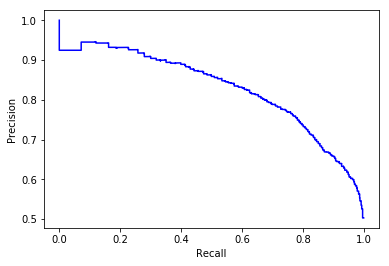

In [47]:
_ = plt.step(recall, precision, color='b', where='post')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')

### Plotting ROC curves for all models

In [48]:
# Plot the ROC curves of our 3 trained models (dummy, logr and rf) 

from sklearn.metrics import roc_curve
fpr_dummy,tpr_dummy,_ = roc_curve(y_test_c, pypos_dummy)
fpr_logr,tpr_logr,_ = roc_curve(y_test_c, pypos_logr)
fpr_rf,tpr_rf,_ = roc_curve(y_test_c, pypos_rf)

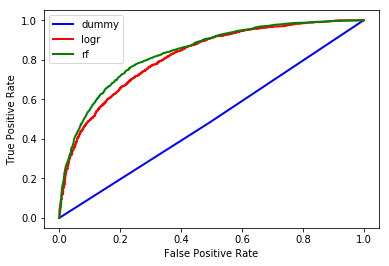

In [49]:
_ = plt.plot(fpr_dummy, tpr_dummy, lw=2, label='dummy', color='b') # curve for dummy
_ = plt.plot(fpr_logr, tpr_logr, lw=2, label='logr', color='r') # curve for logr
_ = plt.plot(fpr_rf, tpr_rf, lw=2, label='rf', color='g')
_ = plt.legend()# add a legend
_ = plt.xlabel('False Positive Rate') # set x-axis label
_ = plt.ylabel('True Positive Rate') # set y-axis label

In [50]:
# Calculate and print the ROC AUC values on the test set for each model
from sklearn.metrics import roc_auc_score
dummy_auc = roc_auc_score(y_test_c, pypos_dummy)
logr_auc = roc_auc_score(y_test_c, pypos_logr)
rf_auc = roc_auc_score(y_test_c, pypos_rf)
print('dummy auc: {:.3f}'.format(dummy_auc))
print('logr auc : {:.3f}'.format(logr_auc))
print('rf auc   : {:.3f}'.format(rf_auc))

dummy auc: 0.494
logr auc : 0.817
rf auc   : 0.837


### Feature selection

In [51]:
# Using the feature importances from the trained Random Forest model, 
#  print the feature name and feature importances for each feature in X
for i in range(X.shape[1]):
    print('{} : {:.3f}'.format(X.columns[i], rf.feature_importances_[i]))

SqFtTotLiving_norm : 0.440
SqFtLot_norm : 0.371
Bathrooms : 0.115
Bedrooms : 0.050
TrafficNoise : 0.024


In [52]:
# Select the most informative features using SelectFromModel using 'mean' as threshold
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold='mean', prefit=True)

In [53]:
# print out the selected features using X.columns and sfm.get_support()
kept_columns = X.columns.values[sfm.get_support()]
print('kept columns: {}'.format(kept_columns))

kept columns: ['SqFtTotLiving_norm' 'SqFtLot_norm']
